In [3]:
!conda install pandas numpy matplotlib plyotly


^C


In [1]:
import os
import json
import pandas as pd
import numpy as np

# 1. 定义路径和标签映射
DATA_DIR = './data'
LABEL_MAP = {
    'others': 0,
    'Flipendo': 1,
    'WingardiumLeviosa': 2
}

# 用于存储所有宽格式数据的列表
wide_data_list = []

print(f"开始处理数据，根目录: {DATA_DIR}")

# 2. 遍历文件夹
for folder_name, label_id in LABEL_MAP.items():
    folder_path = os.path.join(DATA_DIR, folder_name)
    
    if not os.path.exists(folder_path):
        print(f"警告: 文件夹 {folder_path} 不存在，跳过。")
        continue
        
    print(f"正在处理类别: {folder_name} (Label={label_id})...")
    
    file_count = 0
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
            
        file_path = os.path.join(folder_path, filename)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            if 'payload' in data and 'values' in data['payload']:
                values = data['payload']['values']

                np_values = np.array(values)
                
                # ---------------- 相对起始点归一化 ----------------
                start_point = np_values[0] 
                normalized_values = np_values - start_point
                # 将 values (包含多个 [x,y,z] 的列表) 展平为一维数组
                # 例如: [[1,2,3], [4,5,6]] -> [1, 2, 3, 4, 5, 6]
                flat_values = np.array(normalized_values).flatten().tolist()
                
                # 构建这一行的字典，第一列是 label
                row_data = {'label': label_id}
                
                # 动态生成列名并填充数据: x0, y0, z0, x1, y1, z1...
                # 假设 values 里的顺序是 [accX, accY, accZ]
                for i, val in enumerate(flat_values):
                    # i % 3 == 0 -> x, 1 -> y, 2 -> z
                    # i // 3 -> 第几个时间步
                    axis = ['x', 'y', 'z'][i % 3]
                    step = i // 3
                    col_name = f"{axis}{step}"  # 结果如 x0, y0, z0, x1...
                    row_data[col_name] = val
                wide_data_list.append(row_data)
                
                # ---------------- 核心修改逻辑结束 ----------------
                
                file_count += 1
            else:
                print(f"  错误: 文件 {filename} 结构不符合预期")
                
        except Exception as e:
            print(f"  读取文件 {filename} 失败: {e}")

    print(f"  - 已处理 {file_count} 个文件。")

# 5. 转换为 DataFrame 并保存
if wide_data_list:
    df = pd.DataFrame(wide_data_list)

    cols = ['label'] + [c for c in df.columns if c != 'label']
    df = df[cols]
    df = df.fillna(0)

    output_file = 'position_data.csv'
    df.to_csv(output_file, index=False)
    
    print("-" * 30)
    print(f"处理完成！")
    print(f"共提取 {len(df)} 个样本(行)。")
    print(f"特征数量(列): {len(df.columns)} (含label)")
    print(f"文件已保存为: {output_file}")
    print(f"数据预览:")
    print(df.head())
else:
    print("未提取到任何数据。")

开始处理数据，根目录: ./data
正在处理类别: others (Label=0)...
  - 已处理 300 个文件。
正在处理类别: Flipendo (Label=1)...
  - 已处理 300 个文件。
正在处理类别: WingardiumLeviosa (Label=2)...
  - 已处理 300 个文件。
------------------------------
处理完成！
共提取 900 个样本(行)。
特征数量(列): 562 (含label)
文件已保存为: data.csv
数据预览:
   label   x0   y0   z0        x1        y1        z1        x2        y2  \
0      0  0.0  0.0  0.0 -0.009876  0.011369 -0.653914  0.001347  0.028279   
1      0  0.0  0.0  0.0 -0.068983  0.016909 -0.165198 -0.054767  0.013319   
2      0  0.0  0.0  0.0  0.025886  0.025141  0.036954  0.030076  0.026339   
3      0  0.0  0.0  0.0 -0.013618 -0.004341 -0.207244 -0.044892 -0.008381   
4      0  0.0  0.0  0.0 -0.029928 -0.014961 -0.059855 -0.033219  0.001949   

         z2  ...      z183      x184      y184      z184      x185      y185  \
0 -0.682495  ...  1.234213 -0.030526  0.095466  1.176004 -0.086939  0.090078   
1 -0.192133  ... -1.149514  0.024691 -0.060605 -1.156697 -0.005984 -0.069581   
2  0.081396  ... -0.050435 -0.03

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. 读取数据
csv_file = 'position_data.csv'

try:
    df = pd.read_csv(csv_file)
    print(f"成功读取数据，共 {len(df)} 个样本。")
except FileNotFoundError:
    print(f"找不到文件 {csv_file}")
    exit()

# 2. 配置
SAMPLES_PER_CLASS = 1
LABEL_MAP_INV = {
    0: 'others',
    1: 'Flipendo',
    2: 'WingardiumLeviosa'
}

# 3. 创建子图 (1行3列)
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scene'}, {'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=[LABEL_MAP_INV[0], LABEL_MAP_INV[1], LABEL_MAP_INV[2]]
)

print("正在生成交互式 3D 图表...")

for i, label_id in enumerate(LABEL_MAP_INV.keys()):
    class_df = df[df['label'] == label_id]
    if len(class_df) == 0: continue

    n_samples = min(SAMPLES_PER_CLASS, len(class_df))
    sampled_df = class_df.sample(n=n_samples)
    
    for idx, row in sampled_df.iterrows():
        # --- 核心数据还原逻辑 ---
        # 1. 去掉 label 列
        raw_values = row.drop('label').values

        valid_len = len(raw_values) - (len(raw_values) % 3)
        trajectory = raw_values[:valid_len].reshape(-1, 3)

        mask = ~np.all(trajectory == 0, axis=1)
        trajectory = trajectory[mask]
        
        if len(trajectory) == 0: continue
        
        # --- 绘图 ---
        # 动作轨迹线
        fig.add_trace(
            go.Scatter3d(
                x=trajectory[:, 0],
                y=trajectory[:, 1],
                z=trajectory[:, 2],
                mode='lines+markers', # 线+点
                marker=dict(size=2),  # 点稍微小一点
                line=dict(width=3),   # 线宽
                name=f"Sample {idx}",
                showlegend=False      # 隐藏图例，避免太乱
            ),
            row=1, col=i+1
        )
        
        # 标记起点 (绿色大点) - 让你知道动作从哪开始
        fig.add_trace(
            go.Scatter3d(
                x=[trajectory[0, 0]], y=[trajectory[0, 1]], z=[trajectory[0, 2]],
                mode='markers',
                marker=dict(size=5, color='green'),
                name='Start', showlegend=False
            ),
            row=1, col=i+1
        )
        
        # 标记终点 (红色大点)
        fig.add_trace(
            go.Scatter3d(
                x=[trajectory[-1, 0]], y=[trajectory[-1, 1]], z=[trajectory[-1, 2]],
                mode='markers',
                marker=dict(size=5, color='red'),
                name='End', showlegend=False
            ),
            row=1, col=i+1
        )

# 4. 设置布局大小和标题
fig.update_layout(
    height=600, 
    width=1400, 
    title_text="动作轨迹 3D 可视化 (请用鼠标拖拽旋转)",
    showlegend=False
)

fig.show()

成功读取数据，共 900 个样本。
正在生成交互式 3D 图表...


In [4]:
import os
import json
import pandas as pd
import numpy as np

# 1. 定义路径和标签映射
DATA_DIR = './data'
LABEL_MAP = {
    'others': 0,
    'Flipendo': 1,
    'WingardiumLeviosa': 2
}

wide_data_list = []

print(f"开始处理数据，根目录: {DATA_DIR}")
print("⚠️ 模式: 位置(Position) -> 计算加速度(Acceleration)")

# 2. 遍历文件夹
for folder_name, label_id in LABEL_MAP.items():
    folder_path = os.path.join(DATA_DIR, folder_name)
    
    if not os.path.exists(folder_path):
        continue
        
    print(f"正在处理类别: {folder_name} (Label={label_id})...")
    
    file_count = 0
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
            
        file_path = os.path.join(folder_path, filename)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            if 'payload' in data and 'values' in data['payload']:
                values = data['payload']['values']
                
                # 原始数据：位置 [x, y, z] (单位可能是米、厘米或像素)
                pos_data = np.array(values) 
                
                # =======================================================
                # 🌟 核心修改：位置 -> 速度 -> 加速度
                # =======================================================
                
                # 1. 计算一阶导数 (速度 Velocity)
                # axis=0 表示沿时间轴计算
                vel_data = np.gradient(pos_data, axis=0)
                
                # 2. 计算二阶导数 (加速度 Acceleration)
                # 注意：这里计算出的是“线性加速度”(Linear Acceleration)
                # 它不包含重力分量 (Gravity)，静止时接近 0
                acc_data = np.gradient(vel_data, axis=0)
                # 强行截断异常值，防止 14.9 这种数据破坏模型权重
                acc_data = np.clip(acc_data, -4.0, 4.0)
                
                flat_values = acc_data.flatten().tolist()
                
                # =======================================================
                
                row_data = {'label': label_id}
                
                for i, val in enumerate(flat_values):
                    axis = ['x', 'y', 'z'][i % 3]
                    step = i // 3
                    col_name = f"{axis}{step}"
                    row_data[col_name] = val
                
                wide_data_list.append(row_data)
                file_count += 1
            else:
                print(f"  错误: 文件 {filename} 结构不符合预期")
                
        except Exception as e:
            print(f"  读取文件 {filename} 失败: {e}")

    print(f"  - 已处理 {file_count} 个文件。")

# 5. 保存
if wide_data_list:
    df = pd.DataFrame(wide_data_list)
    cols = ['label'] + [c for c in df.columns if c != 'label']
    df = df[cols]
    df = df.fillna(0)

    output_file = 'data_calc_acc.csv'
    df.to_csv(output_file, index=False)
    
    print("-" * 30)
    print(f"✅ 处理完成！")
    print(f"样本数: {len(df)}")
    print(f"特征数: {len(df.columns)}")
    print(f"保存至: {output_file}")
    
    # 打印统计信息，帮你检查缩放是否合理
    data_cols = df.iloc[:, 1:]
    print("\n📊 数据统计 (请检查是否在 -4.0 ~ 4.0 范围内):")
    print(f"Max: {data_cols.max().max():.4f}")
    print(f"Min: {data_cols.min().min():.4f}")
    print(f"Mean: {data_cols.mean().mean():.4f}")
else:
    print("未提取到任何数据。")

开始处理数据，根目录: ./data
⚠️ 模式: 位置(Position) -> 计算加速度(Acceleration)
正在处理类别: others (Label=0)...
  - 已处理 300 个文件。
正在处理类别: Flipendo (Label=1)...
  - 已处理 300 个文件。
正在处理类别: WingardiumLeviosa (Label=2)...
  - 已处理 300 个文件。
------------------------------
✅ 处理完成！
样本数: 900
特征数: 562)
保存至: data_calc_acc.csv

📊 数据统计 (请检查是否在 -4.0 ~ 4.0 范围内):
Max: 4.0000
Min: -4.0000
Mean: 0.0017


In [6]:
import numpy as np
from scipy.interpolate import interp1d
from tensorflow.keras.utils import Sequence

class IMUDataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True, input_shape=(187, 3), augment=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = input_shape
        self.time_steps = input_shape[0]
        self.channels = input_shape[1]
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_X_raw = self.X[indexes]
        batch_y = self.y[indexes]

        if self.augment:
            batch_X = self.__data_augmentation(batch_X_raw)
        else:
            batch_X = batch_X_raw.reshape(-1, self.time_steps, self.channels)

        return np.array(batch_X), np.array(batch_y)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_augmentation(self, X_batch):
        # Reshape to (Batch, Time, Channels)
        X_batch = X_batch.reshape(-1, self.time_steps, self.channels)
        X_aug = np.empty_like(X_batch)

        for i in range(X_batch.shape[0]):
            sample = X_batch[i].copy()
            
            # --- 核心增强逻辑 ---
            # 1. 模拟“握持方向旋转 90 度” (Permutation)
            # 这解决了“上下变成了 y 轴或 x 轴”的问题
            if np.random.rand() < 0.3:
                idx = np.random.permutation(self.channels)
                sample = sample[:, idx]

            # 2. 模拟“握持方向拿反了” (Channel Flip)
            if np.random.rand() < 0.3:
                sample = self._channel_flip(sample)

            # 3. 模拟“握持姿势歪了” (Spatial Rotation)
            # 解决了“稍微拿斜了 30 度”导致能量分散到两个轴上的问题
            if np.random.rand() < 0.4:
                sample = self._spatial_affine(sample)

            # 4. 模拟“用力大小不同” (Scaling)
            if np.random.rand() < 0.5:
                factor = np.random.normal(1.0, 0.1)
                sample *= factor

            # 5. 模拟“动作快慢不一” (Time Warping)
            if np.random.rand() < 0.3:
                sample = self._time_warp(sample)

            # 6. 模拟“手抖/传感器底噪” (Jitter)
            if np.random.rand() < 0.5:
                noise = np.random.normal(0, 0.05, sample.shape)
                sample += noise
            
            X_aug[i] = sample

        return X_aug

    # --- 增强的具体实现 ---
    # 连续弹性变形 (Continuous) Time Warping 生成一条随机波动的“时间曲线”，对整个时间轴进行非线性的挤压和拉伸。
    def _time_warp(self, x, sigma=0.2):
        tt = np.arange(self.time_steps)
        noise = np.random.normal(loc=0, scale=sigma, size=(self.time_steps,))
        tt_new = tt + np.cumsum(noise)
        tt_new = (tt_new - tt_new.min()) / (tt_new.max() - tt_new.min()) * (self.time_steps - 1)
        
        x_new = np.zeros_like(x)
        for i in range(self.channels):
            f = interp1d(tt_new, x[:, i], kind='linear', fill_value="extrapolate")
            x_new[:, i] = f(tt)
        return x_new

    def _channel_flip(self, x):
        # 随机选择某些轴乘以 -1
        # choice: 生成一个 shape 为 (3,) 的向量，包含 1 或 -1
        augment_vector = np.random.choice([1.0, -1.0], size=self.channels)
        return x * augment_vector

    def _spatial_affine(self, x):
        # 使用全 3D 旋转矩阵，模拟任意角度的倾斜握持
        
        # 随机生成三个轴的旋转角度 (-30 ~ +30 度)
        ang_x = np.deg2rad(np.random.uniform(-30, 30))
        ang_y = np.deg2rad(np.random.uniform(-30, 30))
        ang_z = np.deg2rad(np.random.uniform(-30, 30))

        # 构建旋转矩阵 (简化版，叠加三个单轴旋转)
        # 1. 绕 X 轴
        cx, sx = np.cos(ang_x), np.sin(ang_x)
        Rx = np.array([[1, 0, 0], [0, cx, -sx], [0, sx, cx]])
        # 2. 绕 Y 轴
        cy, sy = np.cos(ang_y), np.sin(ang_y)
        Ry = np.array([[cy, 0, sy], [0, 1, 0], [-sy, 0, cy]])
        # 3. 绕 Z 轴
        cz, sz = np.cos(ang_z), np.sin(ang_z)
        Rz = np.array([[cz, -sz, 0], [sz, cz, 0], [0, 0, 1]])
        # 组合旋转 R = Rz * Ry * Rx
        R = np.dot(Rz, np.dot(Ry, Rx))
        x = np.dot(x, R)

        return x

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

csv_file = 'data_calc_acc.csv' # 使用你之前生成的无重力数据
try:
    df = pd.read_csv(csv_file)
    print(f"✅ 数据加载成功，总样本数: {len(df)}")
except FileNotFoundError:
    print("❌ 找不到文件")
    exit()

# 提取特征和标签
if 'filename' in df.columns:
    X = df.drop(['label', 'filename'], axis=1)
else:
    X = df.drop(['label'], axis=1)
y = df['label']

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(
    X.values, y.values, # 转为 numpy array
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"数据形状: {X_train.shape} (样本数, 特征数)")

# ==========================================
# 3. 实例化生成器 (连接数据与模型)
# ==========================================
BATCH_SIZE = 16

train_gen = IMUDataGenerator(
    X_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    augment=True
)

val_gen = IMUDataGenerator(
    X_val, 
    y_val, 
    batch_size=BATCH_SIZE, 
    augment=False
)

✅ 数据加载成功，总样本数: 900
数据形状: (720, 561) (样本数, 特征数)


In [14]:
import tensorflow as tf

INPUT_POINTS = 187   # 采样点数
CHANNELS = 3         # x, y, z
INPUT_SHAPE = INPUT_POINTS * CHANNELS # 558
EMBEDDING_DIM = 16   # 最终输出的特征维度 (Federated Learning 传输用)
NUM_CLASSES = 3      # Others, Flipendo, Wingardium

modelNN = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SHAPE,)),
    tf.keras.layers.Reshape((INPUT_POINTS, CHANNELS)),
    # 输入: (186, 3) -> 输出: (186/4 = 47, 16)
    tf.keras.layers.Conv1D(filters=16, kernel_size=16, strides=4, activation='relu', padding='same'),
    # (47, 16) ->  (11, 16) Pool=4: 47/4 ≈ 11
    tf.keras.layers.MaxPooling1D(pool_size=4),
    # 11 * 16 = 176
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', name='embedding_layer'),
    tf.keras.layers.Dropout(0.2),

    # 注意：导出给 Arduino 时，这一层会被切掉！
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

modelNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 187, 3)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 16)            784       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 16)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 176)               0         
                                                                 
 embedding_layer (Dense)     (None, 16)                2832      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                      

开始训练...
Epoch 1/500
45/45 [==============================] - 1s 6ms/step - loss: 1.1173 - accuracy: 0.3819 - val_loss: 1.0274 - val_accuracy: 0.3977 - lr: 0.0010
Epoch 2/500
45/45 [==============================] - 0s 4ms/step - loss: 0.9647 - accuracy: 0.5639 - val_loss: 0.8347 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 3/500
45/45 [==============================] - 0s 5ms/step - loss: 0.8100 - accuracy: 0.7264 - val_loss: 0.6329 - val_accuracy: 0.8352 - lr: 0.0010
Epoch 4/500
45/45 [==============================] - 0s 5ms/step - loss: 0.6699 - accuracy: 0.7792 - val_loss: 0.4866 - val_accuracy: 0.8920 - lr: 0.0010
Epoch 5/500
45/45 [==============================] - 0s 4ms/step - loss: 0.5458 - accuracy: 0.8306 - val_loss: 0.3876 - val_accuracy: 0.8977 - lr: 0.0010
Epoch 6/500
45/45 [==============================] - 0s 4ms/step - loss: 0.5160 - accuracy: 0.8417 - val_loss: 0.3412 - val_accuracy: 0.8977 - lr: 0.0010
Epoch 7/500
45/45 [==============================] - 0s 4ms/step - l

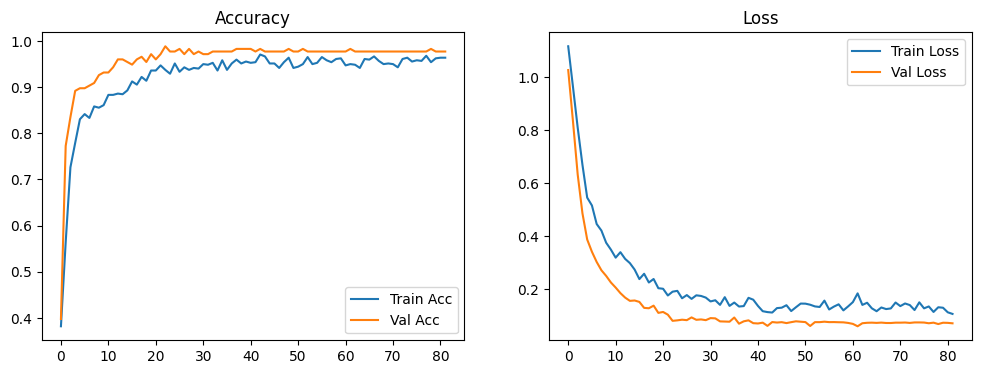

In [15]:
from matplotlib import pyplot as plt
import tensorflow as tf

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.001, 
    weight_decay=0.004
)

modelNN.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy', # 标签是整数(0,1,2)所以用 sparse
    metrics=['accuracy']
)

# ---------------- 4. 训练回调函数 ----------------
callbacks = [
    # 早停：如果验证集 loss 20次没有下降，就停止训练
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss'),
    # 学习率调整：如果 loss 震荡，自动减小学习率
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
]

print("开始训练...")
history = modelNN.fit(
    train_gen,
    validation_data=val_gen,
    epochs=500,          # 最大轮数
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [16]:
import tensorflow as tf

# 1. 切头
feature_extractor = tf.keras.models.Model(
    inputs=modelNN.input, 
    outputs=modelNN.get_layer('embedding_layer').output
)

# 2. 转 TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(feature_extractor)
tflite_model = converter.convert()

# 3. 生成最纯净的 net.h
def tflite_to_c_header(tflite_data, array_name='g_model'):
    c_str = "#ifndef NET_H\n#define NET_H\n\n"
    c_str += f"// TFLite Model\n"
    c_str += f"const unsigned char {array_name}[] = {{\n"
    for i, val in enumerate(tflite_data):
        c_str += f"0x{val:02x}, "
        if (i + 1) % 12 == 0: c_str += "\n"
    c_str += "};\n"
    c_str += f"const int {array_name}_len = {len(tflite_data)};\n"
    c_str += "\n#endif // NET_H\n"
    return c_str

with open('net.h', 'w') as f:
    f.write(tflite_to_c_header(tflite_model))

INFO:tensorflow:Assets written to: C:\Users\19073\AppData\Local\Temp\tmpjiaxg9wj\assets


INFO:tensorflow:Assets written to: C:\Users\19073\AppData\Local\Temp\tmpjiaxg9wj\assets
